### RNNs

* ***What are they? How does the method work?***
* ***How are they useful in ML?***
* ***Describe a usecase which can use the method***
* ***Complete an implementation***

A recurrent neural network is a class of ANN where connections between nodes from a directed graph along a temporal sequence.  This allows it to exhibit temporal dynamic behavior.  Unlike the regular feedforward NN, RNNs can use their internal state memory to process sequences of inputs.  These are networks with loops in them that allow past information to be used in the current state to make decsions.

RNNs are useful in the ML area of handwritting recognition or speech recognition.  A use case for example would be to help computers recognize hand written number digits.

Please refer to later section of this file for RNN implementation.

### LSTMs

* ***What are they? How does the method work?***
* ***How are they useful in ML?***
* ***Describe a usecase which can use the method***
* ***Complete an implementation***

Long short-term memory is an artificial RNN architecture with feedback connections that can not only process single data points (such as images), but also entire sequences of data (such as speech or video). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the exploding and vanishing gradient problems that can be encountered when training traditional RNNs.

Please refer to later section of this file for an example LSTM implementation.

### ***Preparing IMDB Movie Review Dataset for RNN and LSTM Implementations***

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
from tensorflow import keras
#import tensorflow_datasets as tfds
from tensorflow.keras import layers

In [0]:
imdb = keras.datasets.imdb

#num_words=10000 keeps the top 10,000 most frequently occurring words in the training data
vocab_size = 10000

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

In [0]:
print("Training entries: {}, labels: {}".format(len(X_train), len(y_train)))

Training entries: 25000, labels: 25000


In [0]:
print("Testing entries: {}, labels: {}".format(len(X_test), len(y_test)))

Testing entries: 25000, labels: 25000


In [0]:
# sequences in data have different len
# will need to make all sequence length the same in the subsequent blocks
len(X_train[0]), len(X_train[1])

(218, 189)

In [0]:
word_index = imdb.get_word_index()

# increase all word coding by 3 to reserve the first 3
word_index = {k:(v+3) for k,v in word_index.items()}

# add special coding
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# pad_sequences -> standardize lengths of sequences
max_seq_len = 256

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                    value=word_index["<PAD>"],
                                                    padding='post',
                                                    maxlen=max_seq_len)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                   value=word_index["<PAD>"],
                                                   padding='post',
                                                   maxlen=max_seq_len)

In [0]:
# sampling random training data to verify equal length among all sequences
len(X_train[0]), len(X_train[100])

(256, 256)

In [0]:
# create validation set for model fitting
X_validate = X_train[:10000]
X_train_part = X_train[10000:]

y_validate = y_train[:10000]
y_train_part = y_train[10000:]

In [0]:
from keras.models import Sequential
from keras.layers import*

### ***Simple RNN Implementation***

In [0]:
# build RNN model without LSTM
model_simpleRNN=Sequential()
model_simpleRNN.add(Embedding(vocab_size, 32, input_length=max_seq_len))

# add simple RNN layer
model_simpleRNN.add(SimpleRNN(100))

# add output layer
model_simpleRNN.add(Dense(1, activation='sigmoid'))

model_simpleRNN.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

# fit model
model_simpleRNN.fit(X_train_part, y_train_part,
         epochs=40, batch_size=512,
         validation_data=(X_validate, y_validate))

In [0]:
# evaluate simple RNN model
loss, accuracy = model_simpleRNN.evaluate(X_test, y_test)
print('Simple RNN Model Accuracy: {:0.2f}%'.format(accuracy*100))

25000/25000 [==============================] - 76s 3ms/step
Simple RNN Model Accuracy: 51.17%


### ***LSTM Implementation***

In [0]:
# building LSTM model

model = Sequential()

model.add(Embedding(input_dim = vocab_size,
                   input_length = max_seq_len,
                   output_dim = 64,
                   trainable = False,
                   mask_zero = True))
# masking layer to mask any words that do nto have a pre-trained embedding
# masking layer should not be used when trainign the embeddings

model.add(Masking(mask_value=0.0))

# set return_sequences=True when more than one layer are used in the model
model.add(LSTM(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))

# fully connected layer
model.add(Dense(64, activation='relu'))

# dropout for regularization
model.add(Dropout(0.5))

# output layer
model.add(Dense(1, activation='softmax'))

# compile the model
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [0]:
# training and evaluating LSTM model

model.fit(X_train_part, y_train_part,
         epochs=40, batch_size=512,
         validation_data=(X_validate, y_validate))

In [27]:
# evaluate LSTM model
loss, accuracy = model.evaluate(X_test, y_test)
print('LSTM Model Accuracy: {:0.2f}%'.format(accuracy*100))

25000/25000 [==============================] - 144s 6ms/step
LSTM Model Accuracy: 50.00%


### ***GAN Implementation in Keras***

GAN - is an unsupervised deep learning algorithm where a generator is pitted against an adversarial network called discriminator.  The generator generates new data instances while the discriminator evaluates them for authenticity.  The generator creates new and synthetic images in hope of "tricking" the discrimnator into deeming the synthetic as authentic.  The ultimate goal of GAN is to synthesize objects(images, sounds, etc.) that are as close to the real thing as possible.  

GANs are useful ML tools for simulating data, images, sounds, and etc., for purposes such as virtual realities in gaming and/or training.  

In [0]:
from keras.models import*
from keras.layers import*
from keras import optimizers
from tqdm import tqdm

# creating generator

def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy',
                      optimizer=optimizers.Adam(lr=0.0002, beta_1 = 0.5))
    return generator
  
g = create_generator()

g.summary()

In [0]:
# creating discriminator

def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizers.Adam(lr=0.0002, beta_1 = 0.5))
    return discriminator

d = create_discriminator()

d.summary()

In [0]:
# creating GAN

def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

gan = create_gan(d,g)

gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [0]:
# outputing images from real and generated image data

def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [0]:
# training GAN

def training(X_train, y_train, X_test, y_test, epochs=1, batch_size=128):
    
    #Loading the data
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
          
        #generate random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            # We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
            
        if e == 1 or e % 20 == 0:
          plot_generated_images(e, generator)

In [0]:
# Pre-processing data for GAN training

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from keras.datasets import fashion_mnist

# loading fashion MNIST data
(XFash_train, yFash_train), (XFash_test, yFash_test) = fashion_mnist.load_data()

# normalizing data
XFash_train = (XFash_train.astype(np.float32)-127.5)/127.5

# reshape to feed into training func
XFash_train = XFash_train.reshape(-1, 28**2)

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


  5%|▌         | 7/128 [00:00<00:01, 64.03it/s]

Epoch 2


  6%|▋         | 8/128 [00:00<00:01, 73.92it/s]

Epoch 3


  5%|▌         | 7/128 [00:00<00:01, 64.32it/s]

Epoch 4


  6%|▋         | 8/128 [00:00<00:01, 73.19it/s]

Epoch 5


  6%|▋         | 8/128 [00:00<00:01, 75.56it/s]

Epoch 6


  6%|▋         | 8/128 [00:00<00:01, 76.01it/s]

Epoch 7


  6%|▋         | 8/128 [00:00<00:01, 71.52it/s]

Epoch 8


  6%|▋         | 8/128 [00:00<00:01, 72.20it/s]

Epoch 9


  6%|▋         | 8/128 [00:00<00:01, 73.36it/s]

Epoch 10


  6%|▋         | 8/128 [00:00<00:01, 72.61it/s]

Epoch 11


  6%|▋         | 8/128 [00:00<00:01, 73.88it/s]

Epoch 12


  6%|▋         | 8/128 [00:00<00:01, 74.65it/s]

Epoch 13


  6%|▋         | 8/128 [00:00<00:01, 75.12it/s]

Epoch 14


  6%|▋         | 8/128 [00:00<00:01, 72.80it/s]

Epoch 15


  6%|▋         | 8/128 [00:00<00:01, 73.38it/s]

Epoch 16


  6%|▋         | 8/128 [00:00<00:01, 76.00it/s]

Epoch 17


  6%|▋         | 8/128 [00:00<00:01, 73.71it/s]

Epoch 18


  6%|▋         | 8/128 [00:00<00:01, 73.47it/s]

Epoch 19


  6%|▋         | 8/128 [00:00<00:01, 76.01it/s]

Epoch 20


  5%|▌         | 7/128 [00:00<00:01, 65.96it/s]

Epoch 21


  6%|▋         | 8/128 [00:00<00:01, 72.70it/s]

Epoch 22


  6%|▋         | 8/128 [00:00<00:01, 72.61it/s]

Epoch 23


  5%|▌         | 7/128 [00:00<00:01, 66.28it/s]

Epoch 24


  6%|▋         | 8/128 [00:00<00:01, 72.67it/s]

Epoch 25


  6%|▋         | 8/128 [00:00<00:01, 72.71it/s]

Epoch 26


  6%|▋         | 8/128 [00:00<00:01, 72.27it/s]

Epoch 27


  6%|▋         | 8/128 [00:00<00:01, 75.22it/s]

Epoch 28


  6%|▋         | 8/128 [00:00<00:01, 74.33it/s]

Epoch 29


  6%|▋         | 8/128 [00:00<00:01, 74.55it/s]

Epoch 30


  6%|▋         | 8/128 [00:00<00:01, 72.24it/s]

Epoch 31


  6%|▋         | 8/128 [00:00<00:01, 75.46it/s]

Epoch 32


  6%|▋         | 8/128 [00:00<00:01, 76.56it/s]

Epoch 33


  6%|▋         | 8/128 [00:00<00:01, 73.16it/s]

Epoch 34


  6%|▋         | 8/128 [00:00<00:01, 75.03it/s]

Epoch 35


  6%|▋         | 8/128 [00:00<00:01, 72.87it/s]

Epoch 36


  6%|▋         | 8/128 [00:00<00:01, 73.38it/s]

Epoch 37


  6%|▋         | 8/128 [00:00<00:01, 72.41it/s]

Epoch 38


  6%|▋         | 8/128 [00:00<00:01, 74.26it/s]

Epoch 39


  6%|▋         | 8/128 [00:00<00:01, 74.31it/s]

Epoch 40


  5%|▌         | 7/128 [00:00<00:01, 66.27it/s]

Epoch 41


  6%|▋         | 8/128 [00:00<00:01, 74.49it/s]

Epoch 42


  6%|▋         | 8/128 [00:00<00:01, 73.70it/s]

Epoch 43


  6%|▋         | 8/128 [00:00<00:01, 74.86it/s]

Epoch 44


  6%|▋         | 8/128 [00:00<00:01, 72.04it/s]

Epoch 45


  6%|▋         | 8/128 [00:00<00:01, 73.19it/s]

Epoch 46


  6%|▋         | 8/128 [00:00<00:01, 74.55it/s]

Epoch 47


  6%|▋         | 8/128 [00:00<00:01, 72.89it/s]

Epoch 48


  6%|▋         | 8/128 [00:00<00:01, 73.40it/s]

Epoch 49


  6%|▋         | 8/128 [00:00<00:01, 73.21it/s]

Epoch 50


  6%|▋         | 8/128 [00:00<00:01, 73.14it/s]

Epoch 51


  6%|▋         | 8/128 [00:00<00:01, 72.34it/s]

Epoch 52


  5%|▌         | 7/128 [00:00<00:01, 62.85it/s]

Epoch 53


  6%|▋         | 8/128 [00:00<00:01, 72.32it/s]

Epoch 54


  6%|▋         | 8/128 [00:00<00:01, 74.69it/s]

Epoch 55


  5%|▌         | 7/128 [00:00<00:01, 68.43it/s]

Epoch 56


  6%|▋         | 8/128 [00:00<00:01, 73.89it/s]

Epoch 57


  6%|▋         | 8/128 [00:00<00:01, 75.71it/s]

Epoch 58


  5%|▌         | 7/128 [00:00<00:01, 69.21it/s]

Epoch 59


  6%|▋         | 8/128 [00:00<00:01, 74.65it/s]

Epoch 60


  5%|▌         | 7/128 [00:00<00:01, 65.70it/s]

Epoch 61


  6%|▋         | 8/128 [00:00<00:01, 74.48it/s]

Epoch 62


  6%|▋         | 8/128 [00:00<00:01, 71.00it/s]

Epoch 63


  6%|▋         | 8/128 [00:00<00:01, 75.84it/s]

Epoch 64


  6%|▋         | 8/128 [00:00<00:01, 74.30it/s]

Epoch 65


  6%|▋         | 8/128 [00:00<00:01, 73.52it/s]

Epoch 66


  6%|▋         | 8/128 [00:00<00:01, 71.54it/s]

Epoch 67


  6%|▋         | 8/128 [00:00<00:01, 73.51it/s]

Epoch 68


  6%|▋         | 8/128 [00:00<00:01, 72.83it/s]

Epoch 69


  6%|▋         | 8/128 [00:00<00:01, 72.03it/s]

Epoch 70


  6%|▋         | 8/128 [00:00<00:01, 74.63it/s]

Epoch 71


  6%|▋         | 8/128 [00:00<00:01, 74.61it/s]

Epoch 72


  6%|▋         | 8/128 [00:00<00:01, 74.31it/s]

Epoch 73


  6%|▋         | 8/128 [00:00<00:01, 74.37it/s]

Epoch 74


  6%|▋         | 8/128 [00:00<00:01, 76.70it/s]

Epoch 75


  6%|▋         | 8/128 [00:00<00:01, 74.57it/s]

Epoch 76


  6%|▋         | 8/128 [00:00<00:01, 70.80it/s]

Epoch 77


  6%|▋         | 8/128 [00:00<00:01, 74.21it/s]

Epoch 78


  6%|▋         | 8/128 [00:00<00:01, 73.28it/s]

Epoch 79


  6%|▋         | 8/128 [00:00<00:01, 73.36it/s]

Epoch 80


  5%|▌         | 7/128 [00:00<00:01, 64.47it/s]

Epoch 81


  6%|▋         | 8/128 [00:00<00:01, 71.89it/s]

Epoch 82


  5%|▌         | 7/128 [00:00<00:01, 69.07it/s]

Epoch 83


  6%|▋         | 8/128 [00:00<00:01, 72.92it/s]

Epoch 84


  6%|▋         | 8/128 [00:00<00:01, 74.56it/s]

Epoch 85


  6%|▋         | 8/128 [00:00<00:01, 75.30it/s]

Epoch 86


  6%|▋         | 8/128 [00:00<00:01, 71.57it/s]

Epoch 87


  6%|▋         | 8/128 [00:00<00:01, 75.83it/s]

Epoch 88


  6%|▋         | 8/128 [00:00<00:01, 74.55it/s]

Epoch 89


  5%|▌         | 7/128 [00:00<00:01, 69.01it/s]

Epoch 90


  6%|▋         | 8/128 [00:00<00:01, 75.01it/s]

Epoch 91


  6%|▋         | 8/128 [00:00<00:01, 76.25it/s]

Epoch 92


  6%|▋         | 8/128 [00:00<00:01, 75.44it/s]

Epoch 93


  6%|▋         | 8/128 [00:00<00:01, 73.66it/s]

Epoch 94


  6%|▋         | 8/128 [00:00<00:01, 74.44it/s]

Epoch 95


  6%|▋         | 8/128 [00:00<00:01, 73.84it/s]

Epoch 96


  5%|▌         | 7/128 [00:00<00:01, 68.93it/s]

Epoch 97


  6%|▋         | 8/128 [00:00<00:01, 70.56it/s]

Epoch 98


  5%|▌         | 7/128 [00:00<00:01, 69.94it/s]

Epoch 99


  6%|▋         | 8/128 [00:00<00:01, 73.47it/s]

Epoch 100


  5%|▌         | 7/128 [00:00<00:01, 64.31it/s]

Epoch 101


  5%|▌         | 7/128 [00:00<00:01, 68.64it/s]

Epoch 102


  6%|▋         | 8/128 [00:00<00:01, 75.20it/s]

Epoch 103


  6%|▋         | 8/128 [00:00<00:01, 76.03it/s]

Epoch 104


  6%|▋         | 8/128 [00:00<00:01, 74.44it/s]

Epoch 105


  6%|▋         | 8/128 [00:00<00:01, 76.70it/s]

Epoch 106


  6%|▋         | 8/128 [00:00<00:01, 73.15it/s]

Epoch 107


  6%|▋         | 8/128 [00:00<00:01, 74.46it/s]

Epoch 108


  6%|▋         | 8/128 [00:00<00:01, 75.66it/s]

Epoch 109


  6%|▋         | 8/128 [00:00<00:01, 73.02it/s]

Epoch 110


  6%|▋         | 8/128 [00:00<00:01, 72.16it/s]

Epoch 111


  6%|▋         | 8/128 [00:00<00:01, 73.96it/s]

Epoch 112


  5%|▌         | 7/128 [00:00<00:01, 67.34it/s]

Epoch 113


  6%|▋         | 8/128 [00:00<00:01, 73.44it/s]

Epoch 114


  5%|▌         | 7/128 [00:00<00:01, 68.54it/s]

Epoch 115


  6%|▋         | 8/128 [00:00<00:01, 74.09it/s]

Epoch 116


  6%|▋         | 8/128 [00:00<00:01, 74.54it/s]

Epoch 117


  6%|▋         | 8/128 [00:00<00:01, 74.69it/s]

Epoch 118


  6%|▋         | 8/128 [00:00<00:01, 73.97it/s]

Epoch 119


  5%|▌         | 7/128 [00:00<00:01, 66.94it/s]

Epoch 120


  5%|▌         | 7/128 [00:00<00:01, 62.67it/s]

Epoch 121


  5%|▌         | 7/128 [00:00<00:01, 69.15it/s]

Epoch 122


  6%|▋         | 8/128 [00:00<00:01, 72.45it/s]

Epoch 123


  6%|▋         | 8/128 [00:00<00:01, 70.96it/s]

Epoch 124


  6%|▋         | 8/128 [00:00<00:01, 72.64it/s]

Epoch 125


  6%|▋         | 8/128 [00:00<00:01, 71.25it/s]

Epoch 126


  6%|▋         | 8/128 [00:00<00:01, 75.36it/s]

Epoch 127


  6%|▋         | 8/128 [00:00<00:01, 73.53it/s]

Epoch 128


  6%|▋         | 8/128 [00:00<00:01, 71.09it/s]

Epoch 129


  6%|▋         | 8/128 [00:00<00:01, 77.08it/s]

Epoch 130


  6%|▋         | 8/128 [00:00<00:01, 74.01it/s]

Epoch 131


  6%|▋         | 8/128 [00:00<00:01, 73.26it/s]

Epoch 132


  6%|▋         | 8/128 [00:00<00:01, 72.37it/s]

Epoch 133


  6%|▋         | 8/128 [00:00<00:01, 75.84it/s]

Epoch 134


  6%|▋         | 8/128 [00:00<00:01, 75.82it/s]

Epoch 135


  5%|▌         | 7/128 [00:00<00:01, 68.51it/s]

Epoch 136


  6%|▋         | 8/128 [00:00<00:01, 73.38it/s]

Epoch 137


  6%|▋         | 8/128 [00:00<00:01, 71.23it/s]

Epoch 138


  6%|▋         | 8/128 [00:00<00:01, 76.75it/s]

Epoch 139


  6%|▋         | 8/128 [00:00<00:01, 74.48it/s]

Epoch 140


  5%|▌         | 7/128 [00:00<00:01, 66.05it/s]

Epoch 141


  6%|▋         | 8/128 [00:00<00:01, 73.15it/s]

Epoch 142


  6%|▋         | 8/128 [00:00<00:01, 75.34it/s]

Epoch 143


  5%|▌         | 7/128 [00:00<00:01, 69.49it/s]

Epoch 144


  6%|▋         | 8/128 [00:00<00:01, 74.19it/s]

Epoch 145


  6%|▋         | 8/128 [00:00<00:01, 74.64it/s]

Epoch 146


  6%|▋         | 8/128 [00:00<00:01, 73.52it/s]

Epoch 147


  6%|▋         | 8/128 [00:00<00:01, 75.64it/s]

Epoch 148


  6%|▋         | 8/128 [00:00<00:01, 75.54it/s]

Epoch 149


  6%|▋         | 8/128 [00:00<00:01, 74.79it/s]

Epoch 150


  5%|▌         | 7/128 [00:00<00:01, 65.33it/s]

Epoch 151


  6%|▋         | 8/128 [00:00<00:01, 74.48it/s]

Epoch 152


  6%|▋         | 8/128 [00:00<00:01, 75.21it/s]

Epoch 153


  6%|▋         | 8/128 [00:00<00:01, 75.17it/s]

Epoch 154


  6%|▋         | 8/128 [00:00<00:01, 75.41it/s]

Epoch 155


  6%|▋         | 8/128 [00:00<00:01, 75.96it/s]

Epoch 156


  6%|▋         | 8/128 [00:00<00:01, 72.17it/s]

Epoch 157


  6%|▋         | 8/128 [00:00<00:01, 76.11it/s]

Epoch 158


  6%|▋         | 8/128 [00:00<00:01, 74.04it/s]

Epoch 159


  6%|▋         | 8/128 [00:00<00:01, 74.00it/s]

Epoch 160


  5%|▍         | 6/128 [00:00<00:02, 59.71it/s]

Epoch 161


  6%|▋         | 8/128 [00:00<00:01, 70.93it/s]

Epoch 162


  6%|▋         | 8/128 [00:00<00:01, 73.82it/s]

Epoch 163


  6%|▋         | 8/128 [00:00<00:01, 77.46it/s]

Epoch 164


  6%|▋         | 8/128 [00:00<00:01, 75.77it/s]

Epoch 165


  5%|▌         | 7/128 [00:00<00:01, 69.48it/s]

Epoch 166


  6%|▋         | 8/128 [00:00<00:01, 75.42it/s]

Epoch 167


  6%|▋         | 8/128 [00:00<00:01, 75.03it/s]

Epoch 168


  6%|▋         | 8/128 [00:00<00:01, 74.18it/s]

Epoch 169


  6%|▋         | 8/128 [00:00<00:01, 75.52it/s]

Epoch 170


  6%|▋         | 8/128 [00:00<00:01, 74.27it/s]

Epoch 171


  6%|▋         | 8/128 [00:00<00:01, 75.67it/s]

Epoch 172


  5%|▌         | 7/128 [00:00<00:01, 66.53it/s]

Epoch 173


  6%|▋         | 8/128 [00:00<00:01, 74.36it/s]

Epoch 174


  5%|▌         | 7/128 [00:00<00:01, 69.18it/s]

Epoch 175


  6%|▋         | 8/128 [00:00<00:01, 75.46it/s]

Epoch 176


  6%|▋         | 8/128 [00:00<00:01, 74.74it/s]

Epoch 177


  6%|▋         | 8/128 [00:00<00:01, 74.10it/s]

Epoch 178


  6%|▋         | 8/128 [00:00<00:01, 73.22it/s]

Epoch 179


  6%|▋         | 8/128 [00:00<00:01, 74.18it/s]

Epoch 180


  5%|▌         | 7/128 [00:00<00:01, 63.97it/s]

Epoch 181


  6%|▋         | 8/128 [00:00<00:01, 72.22it/s]

Epoch 182


  6%|▋         | 8/128 [00:00<00:01, 71.93it/s]

Epoch 183


  6%|▋         | 8/128 [00:00<00:01, 73.25it/s]

Epoch 184


  6%|▋         | 8/128 [00:00<00:01, 71.55it/s]

Epoch 185


  6%|▋         | 8/128 [00:00<00:01, 73.58it/s]

Epoch 186


  6%|▋         | 8/128 [00:00<00:01, 74.08it/s]

Epoch 187


  6%|▋         | 8/128 [00:00<00:01, 74.45it/s]

Epoch 188


  6%|▋         | 8/128 [00:00<00:01, 73.48it/s]

Epoch 189


  6%|▋         | 8/128 [00:00<00:01, 70.78it/s]

Epoch 190


  6%|▋         | 8/128 [00:00<00:01, 75.27it/s]

Epoch 191


  5%|▌         | 7/128 [00:00<00:01, 66.95it/s]

Epoch 192


  6%|▋         | 8/128 [00:00<00:01, 73.24it/s]

Epoch 193


  6%|▋         | 8/128 [00:00<00:01, 72.70it/s]

Epoch 194


  6%|▋         | 8/128 [00:00<00:01, 72.86it/s]

Epoch 195


  6%|▋         | 8/128 [00:00<00:01, 75.44it/s]

Epoch 196


  6%|▋         | 8/128 [00:00<00:01, 72.86it/s]

Epoch 197


  6%|▋         | 8/128 [00:00<00:01, 75.18it/s]

Epoch 198


  5%|▌         | 7/128 [00:00<00:01, 66.94it/s]

Epoch 199


  6%|▋         | 8/128 [00:00<00:01, 74.20it/s]

Epoch 200


  5%|▌         | 7/128 [00:00<00:01, 65.18it/s]

Epoch 201


  6%|▋         | 8/128 [00:00<00:01, 74.23it/s]

Epoch 202


  6%|▋         | 8/128 [00:00<00:01, 74.33it/s]

Epoch 203


  5%|▌         | 7/128 [00:00<00:01, 67.79it/s]

Epoch 204


  6%|▋         | 8/128 [00:00<00:01, 73.44it/s]

Epoch 205


  6%|▋         | 8/128 [00:00<00:01, 73.22it/s]

Epoch 206


  6%|▋         | 8/128 [00:00<00:01, 73.99it/s]

Epoch 207


  6%|▋         | 8/128 [00:00<00:01, 74.58it/s]

Epoch 208


  6%|▋         | 8/128 [00:00<00:01, 71.68it/s]

Epoch 209


  5%|▌         | 7/128 [00:00<00:01, 65.97it/s]

Epoch 210


  5%|▌         | 7/128 [00:00<00:01, 68.16it/s]

Epoch 211


  6%|▋         | 8/128 [00:00<00:01, 73.53it/s]

Epoch 212


  6%|▋         | 8/128 [00:00<00:01, 75.10it/s]

Epoch 213


  6%|▋         | 8/128 [00:00<00:01, 74.56it/s]

Epoch 214


  6%|▋         | 8/128 [00:00<00:01, 76.03it/s]

Epoch 215


  6%|▋         | 8/128 [00:00<00:01, 75.75it/s]

Epoch 216


  6%|▋         | 8/128 [00:00<00:01, 76.13it/s]

Epoch 217


  6%|▋         | 8/128 [00:00<00:01, 74.24it/s]

Epoch 218


  6%|▋         | 8/128 [00:00<00:01, 74.06it/s]

Epoch 219


  6%|▋         | 8/128 [00:00<00:01, 73.65it/s]

Epoch 220


  5%|▌         | 7/128 [00:00<00:01, 66.51it/s]

Epoch 221


  6%|▋         | 8/128 [00:00<00:01, 73.76it/s]

Epoch 222


  5%|▌         | 7/128 [00:00<00:01, 67.21it/s]

Epoch 223


  6%|▋         | 8/128 [00:00<00:01, 71.58it/s]

Epoch 224


  6%|▋         | 8/128 [00:00<00:01, 73.55it/s]

Epoch 225


  6%|▋         | 8/128 [00:00<00:01, 76.22it/s]

Epoch 226


  6%|▋         | 8/128 [00:00<00:01, 75.96it/s]

Epoch 227


  6%|▋         | 8/128 [00:00<00:01, 73.98it/s]

Epoch 228


  6%|▋         | 8/128 [00:00<00:01, 75.82it/s]

Epoch 229


  5%|▌         | 7/128 [00:00<00:01, 68.15it/s]

Epoch 230


  6%|▋         | 8/128 [00:00<00:01, 72.97it/s]

Epoch 231


  6%|▋         | 8/128 [00:00<00:01, 75.35it/s]

Epoch 232


  6%|▋         | 8/128 [00:00<00:01, 73.13it/s]

Epoch 233


  6%|▋         | 8/128 [00:00<00:01, 75.63it/s]

Epoch 234


  6%|▋         | 8/128 [00:00<00:01, 75.16it/s]

Epoch 235


  6%|▋         | 8/128 [00:00<00:01, 72.41it/s]

Epoch 236


  5%|▌         | 7/128 [00:00<00:01, 68.13it/s]

Epoch 237


  6%|▋         | 8/128 [00:00<00:01, 72.55it/s]

Epoch 238


  6%|▋         | 8/128 [00:00<00:01, 76.84it/s]

Epoch 239


  6%|▋         | 8/128 [00:00<00:01, 75.57it/s]

Epoch 240


  5%|▌         | 7/128 [00:00<00:01, 63.35it/s]

Epoch 241


  6%|▋         | 8/128 [00:00<00:01, 72.92it/s]

Epoch 242


  6%|▋         | 8/128 [00:00<00:01, 72.98it/s]

Epoch 243


  6%|▋         | 8/128 [00:00<00:01, 73.62it/s]

Epoch 244


  6%|▋         | 8/128 [00:00<00:01, 74.49it/s]

Epoch 245


  6%|▋         | 8/128 [00:00<00:01, 72.26it/s]

Epoch 246


  6%|▋         | 8/128 [00:00<00:01, 75.30it/s]

Epoch 247


  6%|▋         | 8/128 [00:00<00:01, 76.64it/s]

Epoch 248


  6%|▋         | 8/128 [00:00<00:01, 73.38it/s]

Epoch 249


  6%|▋         | 8/128 [00:00<00:01, 75.87it/s]

Epoch 250


  6%|▋         | 8/128 [00:00<00:01, 75.37it/s]

Epoch 251


  6%|▋         | 8/128 [00:00<00:01, 76.44it/s]

Epoch 252


  6%|▋         | 8/128 [00:00<00:01, 75.98it/s]

Epoch 253


  6%|▋         | 8/128 [00:00<00:01, 75.93it/s]

Epoch 254


  6%|▋         | 8/128 [00:00<00:01, 75.88it/s]

Epoch 255


  6%|▋         | 8/128 [00:00<00:01, 75.18it/s]

Epoch 256


  6%|▋         | 8/128 [00:00<00:01, 76.21it/s]

Epoch 257


  6%|▋         | 8/128 [00:00<00:01, 75.70it/s]

Epoch 258


  5%|▌         | 7/128 [00:00<00:01, 67.61it/s]

Epoch 259


  5%|▌         | 7/128 [00:00<00:01, 67.99it/s]

Epoch 260


  5%|▌         | 7/128 [00:00<00:01, 62.58it/s]

Epoch 261


  6%|▋         | 8/128 [00:00<00:01, 71.36it/s]

Epoch 262


  5%|▌         | 7/128 [00:00<00:01, 69.85it/s]

Epoch 263


  5%|▌         | 7/128 [00:00<00:01, 68.24it/s]

Epoch 264


  6%|▋         | 8/128 [00:00<00:01, 72.21it/s]

Epoch 265


  6%|▋         | 8/128 [00:00<00:01, 76.01it/s]

Epoch 266


  6%|▋         | 8/128 [00:00<00:01, 73.11it/s]

Epoch 267


  6%|▋         | 8/128 [00:00<00:01, 73.97it/s]

Epoch 268


  5%|▌         | 7/128 [00:00<00:01, 68.28it/s]

Epoch 269


  5%|▌         | 7/128 [00:00<00:01, 67.14it/s]

Epoch 270


  6%|▋         | 8/128 [00:00<00:01, 75.53it/s]

Epoch 271


  6%|▋         | 8/128 [00:00<00:01, 76.81it/s]

Epoch 272


  6%|▋         | 8/128 [00:00<00:01, 77.34it/s]

Epoch 273


  6%|▋         | 8/128 [00:00<00:01, 75.38it/s]

Epoch 274


  6%|▋         | 8/128 [00:00<00:01, 73.56it/s]

Epoch 275


  6%|▋         | 8/128 [00:00<00:01, 76.04it/s]

Epoch 276


  6%|▋         | 8/128 [00:00<00:01, 72.93it/s]

Epoch 277


  6%|▋         | 8/128 [00:00<00:01, 73.70it/s]

Epoch 278


  5%|▌         | 7/128 [00:00<00:01, 69.04it/s]

Epoch 279


  6%|▋         | 8/128 [00:00<00:01, 73.47it/s]

Epoch 280


  5%|▌         | 7/128 [00:00<00:01, 66.27it/s]

Epoch 281


  6%|▋         | 8/128 [00:00<00:01, 68.45it/s]

Epoch 282


  6%|▋         | 8/128 [00:00<00:01, 77.05it/s]

Epoch 283


  6%|▋         | 8/128 [00:00<00:01, 73.66it/s]

Epoch 284


  6%|▋         | 8/128 [00:00<00:01, 76.25it/s]

Epoch 285


  6%|▋         | 8/128 [00:00<00:01, 73.11it/s]

Epoch 286


  6%|▋         | 8/128 [00:00<00:01, 73.61it/s]

Epoch 287


  6%|▋         | 8/128 [00:00<00:01, 75.23it/s]

Epoch 288


  6%|▋         | 8/128 [00:00<00:01, 76.85it/s]

Epoch 289


  6%|▋         | 8/128 [00:00<00:01, 70.79it/s]

Epoch 290


  6%|▋         | 8/128 [00:00<00:01, 76.30it/s]

Epoch 291


  5%|▌         | 7/128 [00:00<00:01, 69.39it/s]

Epoch 292


  6%|▋         | 8/128 [00:00<00:01, 76.92it/s]

Epoch 293


  6%|▋         | 8/128 [00:00<00:01, 73.10it/s]

Epoch 294


  5%|▌         | 7/128 [00:00<00:01, 68.30it/s]

Epoch 295


  6%|▋         | 8/128 [00:00<00:01, 76.28it/s]

Epoch 296


  6%|▋         | 8/128 [00:00<00:01, 77.23it/s]

Epoch 297


  6%|▋         | 8/128 [00:00<00:01, 74.53it/s]

Epoch 298


  6%|▋         | 8/128 [00:00<00:01, 75.43it/s]

Epoch 299


  6%|▋         | 8/128 [00:00<00:01, 74.32it/s]

Epoch 300


  5%|▌         | 7/128 [00:00<00:01, 66.22it/s]

Epoch 301


  6%|▋         | 8/128 [00:00<00:01, 76.74it/s]

Epoch 302


  5%|▌         | 7/128 [00:00<00:01, 67.22it/s]

Epoch 303


  6%|▋         | 8/128 [00:00<00:01, 74.19it/s]

Epoch 304


  6%|▋         | 8/128 [00:00<00:01, 75.55it/s]

Epoch 305


  6%|▋         | 8/128 [00:00<00:01, 76.06it/s]

Epoch 306


  6%|▋         | 8/128 [00:00<00:01, 75.16it/s]

Epoch 307


  6%|▋         | 8/128 [00:00<00:01, 73.91it/s]

Epoch 308


  6%|▋         | 8/128 [00:00<00:01, 74.13it/s]

Epoch 309


  6%|▋         | 8/128 [00:00<00:01, 76.20it/s]

Epoch 310


  6%|▋         | 8/128 [00:00<00:01, 76.92it/s]

Epoch 311


  6%|▋         | 8/128 [00:00<00:01, 75.53it/s]

Epoch 312


  6%|▋         | 8/128 [00:00<00:01, 74.32it/s]

Epoch 313


  6%|▋         | 8/128 [00:00<00:01, 75.00it/s]

Epoch 314


  6%|▋         | 8/128 [00:00<00:01, 71.64it/s]

Epoch 315


  5%|▌         | 7/128 [00:00<00:01, 69.52it/s]

Epoch 316


  6%|▋         | 8/128 [00:00<00:01, 75.84it/s]

Epoch 317


  6%|▋         | 8/128 [00:00<00:01, 74.78it/s]

Epoch 318


  6%|▋         | 8/128 [00:00<00:01, 74.59it/s]

Epoch 319


  6%|▋         | 8/128 [00:00<00:01, 73.21it/s]

Epoch 320


  5%|▌         | 7/128 [00:00<00:01, 67.58it/s]

Epoch 321


  6%|▋         | 8/128 [00:00<00:01, 72.72it/s]

Epoch 322


  6%|▋         | 8/128 [00:00<00:01, 74.04it/s]

Epoch 323


  6%|▋         | 8/128 [00:00<00:01, 75.39it/s]

Epoch 324


  5%|▌         | 7/128 [00:00<00:01, 69.96it/s]

Epoch 325


  6%|▋         | 8/128 [00:00<00:01, 75.27it/s]

Epoch 326


  6%|▋         | 8/128 [00:00<00:01, 77.42it/s]

Epoch 327


  6%|▋         | 8/128 [00:00<00:01, 71.48it/s]

Epoch 328


  6%|▋         | 8/128 [00:00<00:01, 74.23it/s]

Epoch 329


  6%|▋         | 8/128 [00:00<00:01, 74.74it/s]

Epoch 330


  6%|▋         | 8/128 [00:00<00:01, 74.86it/s]

Epoch 331


  5%|▌         | 7/128 [00:00<00:01, 66.36it/s]

Epoch 332


  6%|▋         | 8/128 [00:00<00:01, 76.87it/s]

Epoch 333


  6%|▋         | 8/128 [00:00<00:01, 74.37it/s]

Epoch 334


  6%|▋         | 8/128 [00:00<00:01, 73.58it/s]

Epoch 335


  6%|▋         | 8/128 [00:00<00:01, 72.79it/s]

Epoch 336


  6%|▋         | 8/128 [00:00<00:01, 76.76it/s]

Epoch 337


  6%|▋         | 8/128 [00:00<00:01, 75.54it/s]

Epoch 338


  6%|▋         | 8/128 [00:00<00:01, 74.87it/s]

Epoch 339


  6%|▋         | 8/128 [00:00<00:01, 74.68it/s]

Epoch 340


  5%|▌         | 7/128 [00:00<00:01, 64.72it/s]

Epoch 341


  6%|▋         | 8/128 [00:00<00:01, 75.70it/s]

Epoch 342


  6%|▋         | 8/128 [00:00<00:01, 75.75it/s]

Epoch 343


  6%|▋         | 8/128 [00:00<00:01, 71.33it/s]

Epoch 344


  6%|▋         | 8/128 [00:00<00:01, 74.24it/s]

Epoch 345


  6%|▋         | 8/128 [00:00<00:01, 73.42it/s]

Epoch 346


  6%|▋         | 8/128 [00:00<00:01, 75.08it/s]

Epoch 347


  6%|▋         | 8/128 [00:00<00:01, 75.24it/s]

Epoch 348


  6%|▋         | 8/128 [00:00<00:01, 73.47it/s]

Epoch 349


  6%|▋         | 8/128 [00:00<00:01, 76.42it/s]

Epoch 350


  6%|▋         | 8/128 [00:00<00:01, 74.59it/s]

Epoch 351


  6%|▋         | 8/128 [00:00<00:01, 73.62it/s]

Epoch 352


  6%|▋         | 8/128 [00:00<00:01, 71.60it/s]

Epoch 353


  5%|▌         | 7/128 [00:00<00:01, 66.74it/s]

Epoch 354


  6%|▋         | 8/128 [00:00<00:01, 73.83it/s]

Epoch 355


  6%|▋         | 8/128 [00:00<00:01, 76.70it/s]

Epoch 356


  6%|▋         | 8/128 [00:00<00:01, 73.82it/s]

Epoch 357


  6%|▋         | 8/128 [00:00<00:01, 74.43it/s]

Epoch 358


  6%|▋         | 8/128 [00:00<00:01, 75.98it/s]

Epoch 359


  6%|▋         | 8/128 [00:00<00:01, 71.33it/s]

Epoch 360


  5%|▌         | 7/128 [00:00<00:01, 65.60it/s]

Epoch 361


  6%|▋         | 8/128 [00:00<00:01, 75.19it/s]

Epoch 362


  6%|▋         | 8/128 [00:00<00:01, 72.92it/s]

Epoch 363


  6%|▋         | 8/128 [00:00<00:01, 73.85it/s]

Epoch 364


  6%|▋         | 8/128 [00:00<00:01, 70.56it/s]

Epoch 365


  6%|▋         | 8/128 [00:00<00:01, 75.10it/s]

Epoch 366


  6%|▋         | 8/128 [00:00<00:01, 75.62it/s]

Epoch 367


  6%|▋         | 8/128 [00:00<00:01, 76.33it/s]

Epoch 368


  6%|▋         | 8/128 [00:00<00:01, 73.55it/s]

Epoch 369


  6%|▋         | 8/128 [00:00<00:01, 75.31it/s]

Epoch 370


  6%|▋         | 8/128 [00:00<00:01, 75.02it/s]

Epoch 371


  5%|▌         | 7/128 [00:00<00:01, 68.76it/s]

Epoch 372


  6%|▋         | 8/128 [00:00<00:01, 74.99it/s]

Epoch 373


  5%|▌         | 7/128 [00:00<00:01, 67.53it/s]

Epoch 374


  5%|▌         | 7/128 [00:00<00:01, 69.58it/s]

Epoch 375


  6%|▋         | 8/128 [00:00<00:01, 74.73it/s]

Epoch 376


  6%|▋         | 8/128 [00:00<00:01, 75.40it/s]

Epoch 377


  6%|▋         | 8/128 [00:00<00:01, 75.82it/s]

Epoch 378


  6%|▋         | 8/128 [00:00<00:01, 75.11it/s]

Epoch 379


  6%|▋         | 8/128 [00:00<00:01, 74.84it/s]

Epoch 380


  5%|▌         | 7/128 [00:00<00:01, 65.42it/s]

Epoch 381


  6%|▋         | 8/128 [00:00<00:01, 75.22it/s]

Epoch 382


  6%|▋         | 8/128 [00:00<00:01, 73.53it/s]

Epoch 383


  6%|▋         | 8/128 [00:00<00:01, 73.87it/s]

Epoch 384


  6%|▋         | 8/128 [00:00<00:01, 74.09it/s]

Epoch 385


  6%|▋         | 8/128 [00:00<00:01, 72.91it/s]

Epoch 386


  5%|▌         | 7/128 [00:00<00:01, 66.22it/s]

Epoch 387


  6%|▋         | 8/128 [00:00<00:01, 74.26it/s]

Epoch 388


  6%|▋         | 8/128 [00:00<00:01, 75.77it/s]

Epoch 389


  6%|▋         | 8/128 [00:00<00:01, 73.38it/s]

Epoch 390


  6%|▋         | 8/128 [00:00<00:01, 74.87it/s]

Epoch 391


  6%|▋         | 8/128 [00:00<00:01, 74.85it/s]

Epoch 392


  6%|▋         | 8/128 [00:00<00:01, 74.02it/s]

Epoch 393


  6%|▋         | 8/128 [00:00<00:01, 71.64it/s]

Epoch 394


  6%|▋         | 8/128 [00:00<00:01, 74.37it/s]

Epoch 395


  6%|▋         | 8/128 [00:00<00:01, 75.03it/s]

Epoch 396


  5%|▌         | 7/128 [00:00<00:01, 67.11it/s]

Epoch 397


  6%|▋         | 8/128 [00:00<00:01, 72.37it/s]

Epoch 398


  6%|▋         | 8/128 [00:00<00:01, 76.03it/s]

Epoch 399


  6%|▋         | 8/128 [00:00<00:01, 72.45it/s]

Epoch 400


100%|██████████| 128/128 [00:01<00:00, 74.57it/s]
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


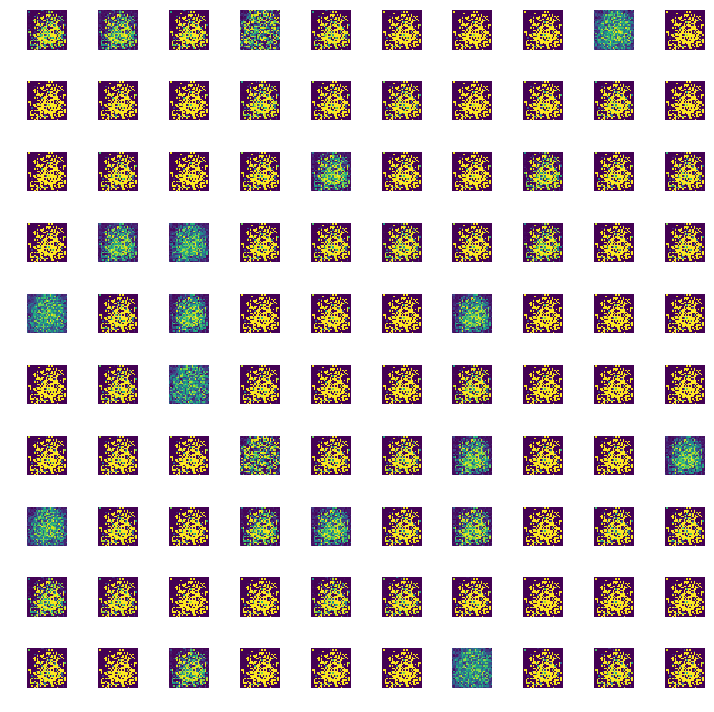

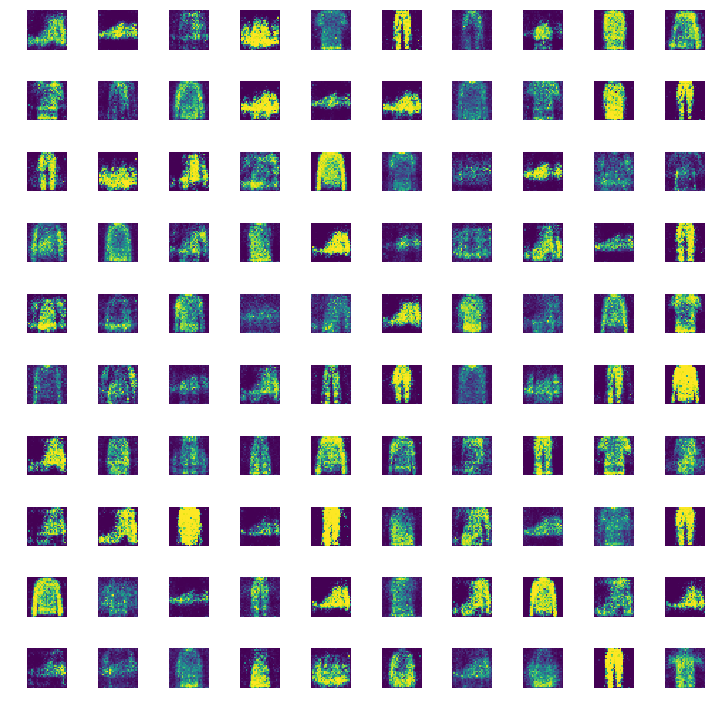

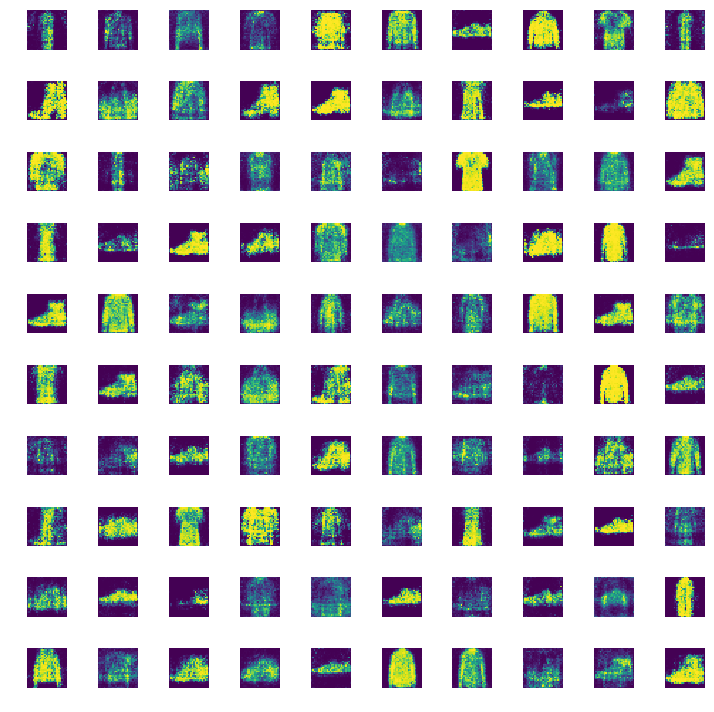

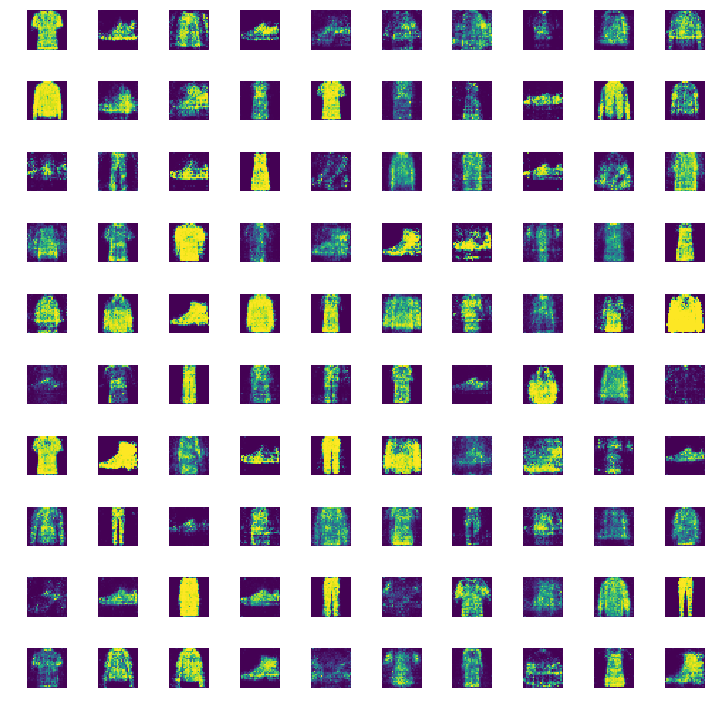

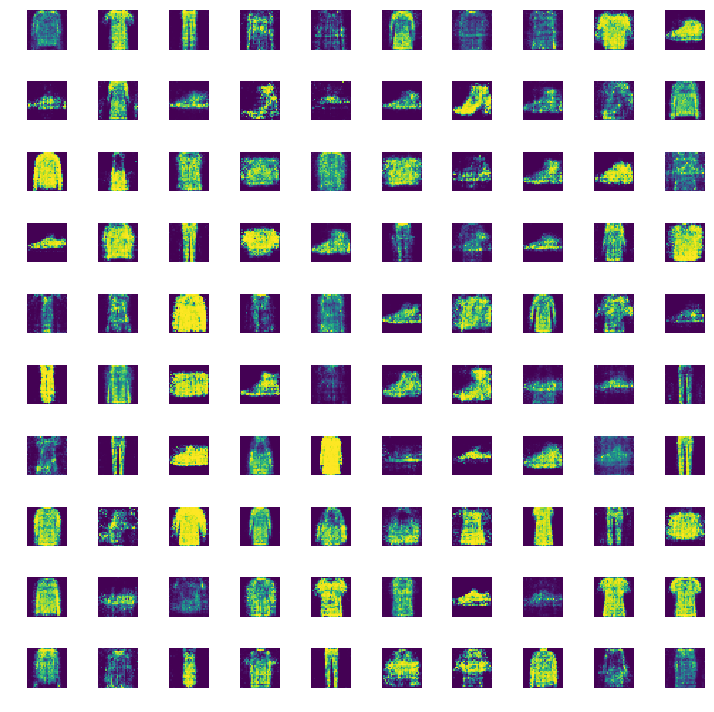

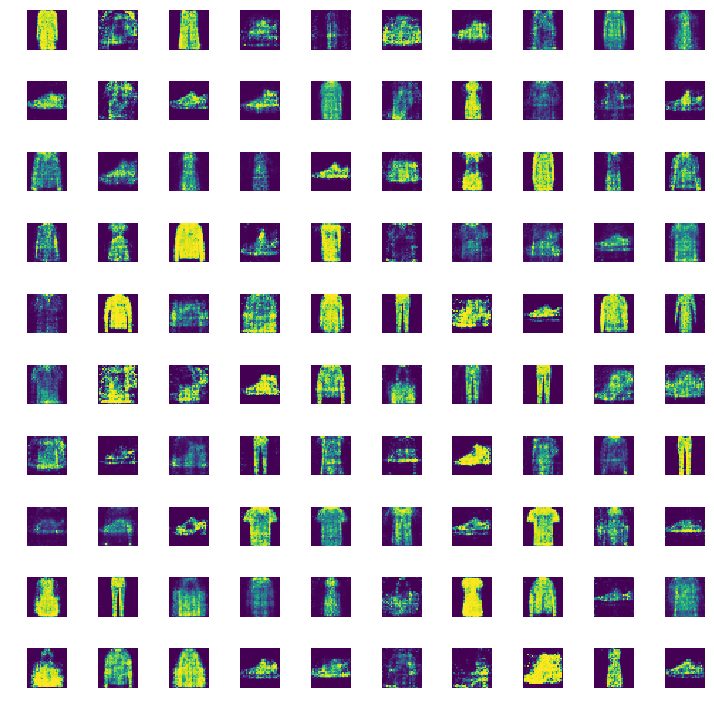

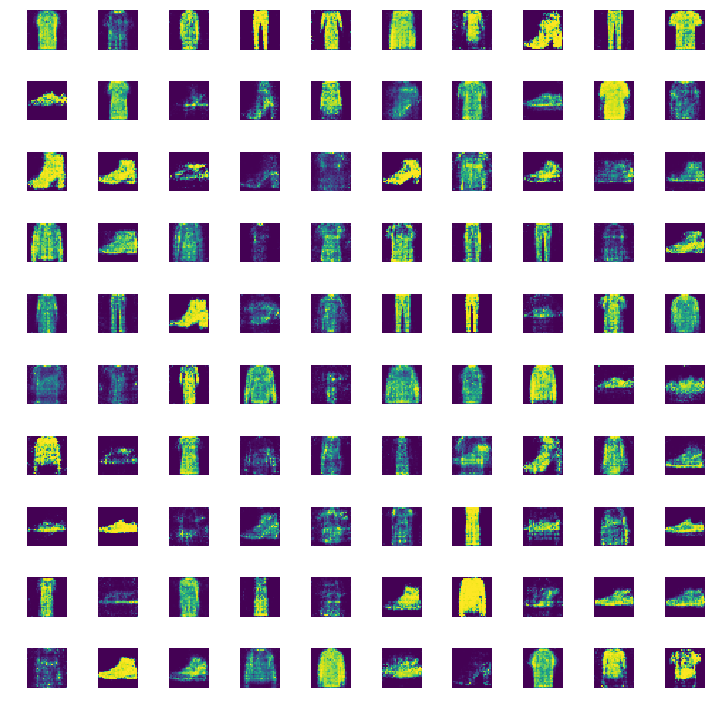

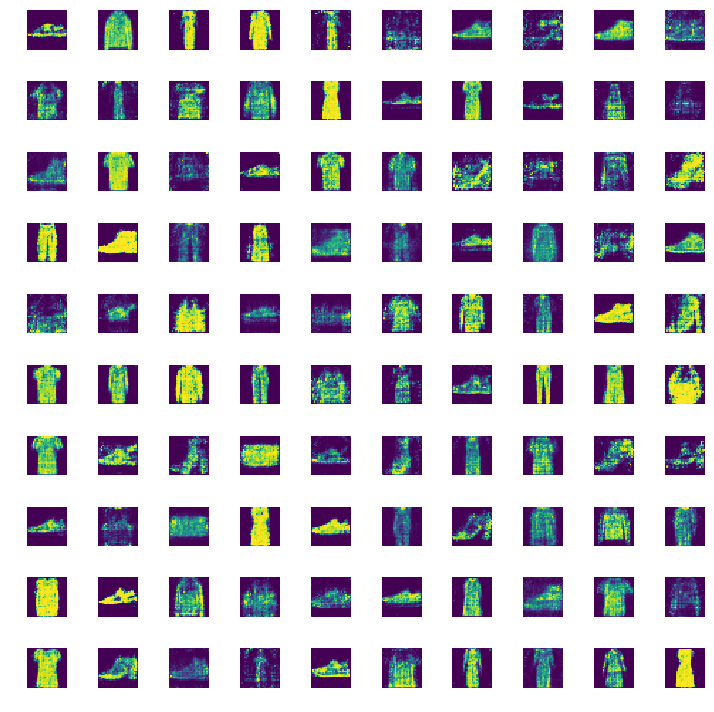

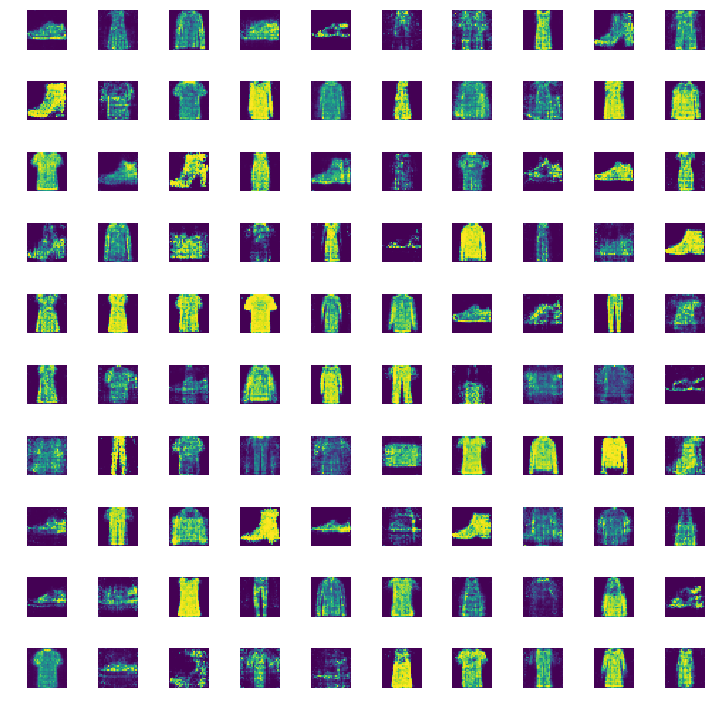

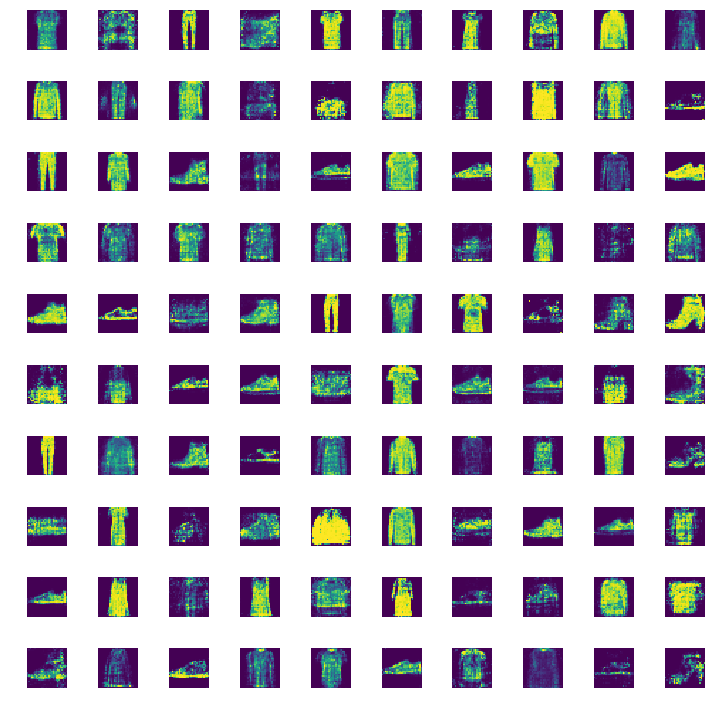

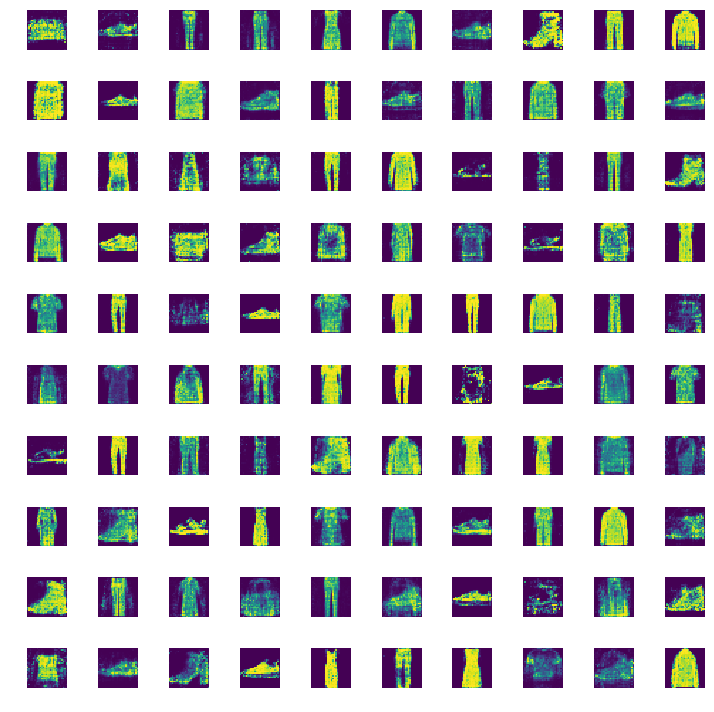

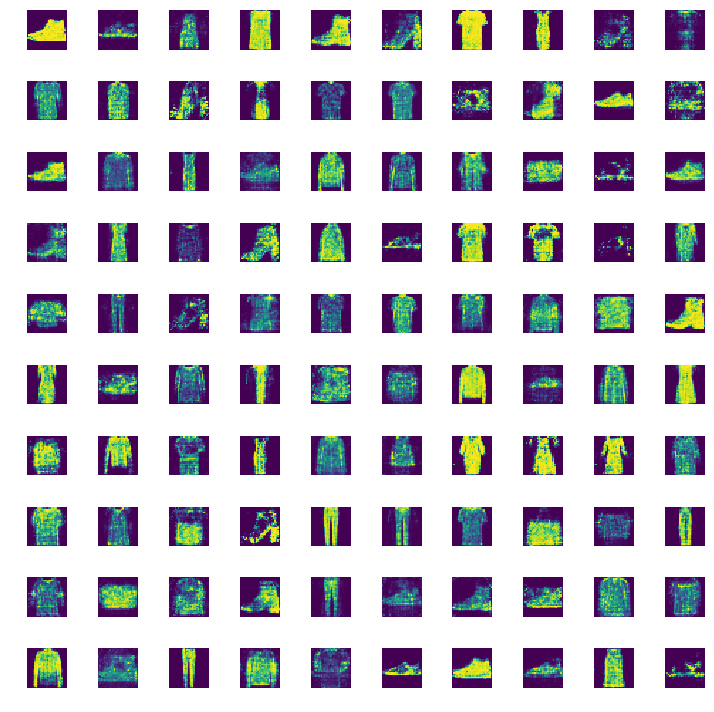

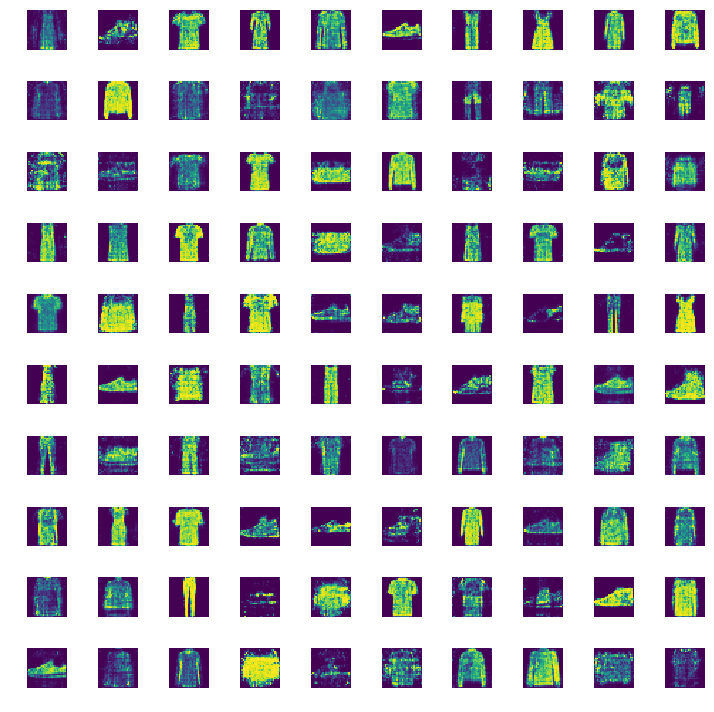

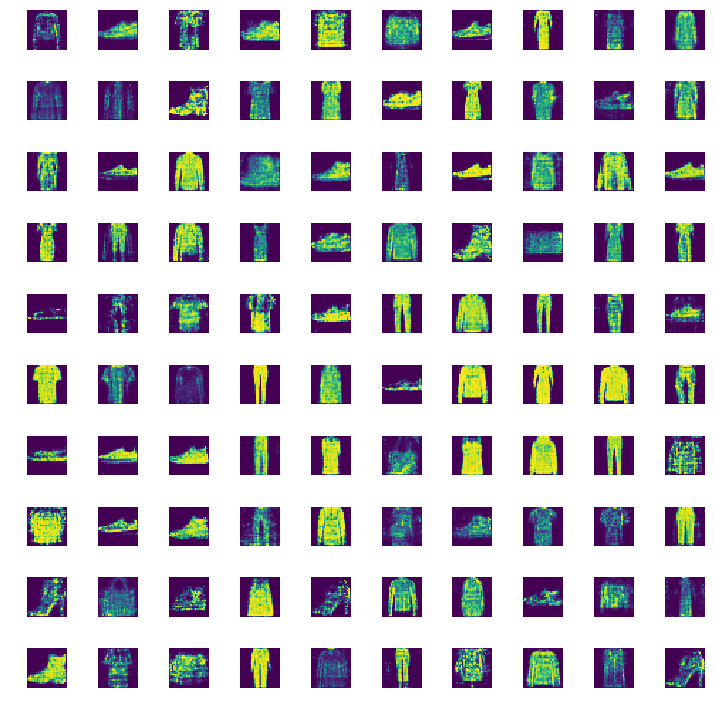

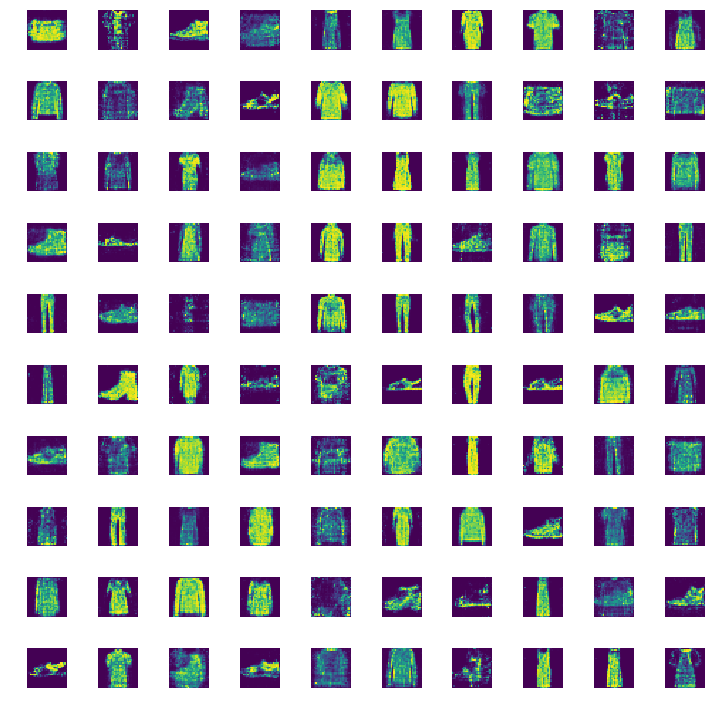

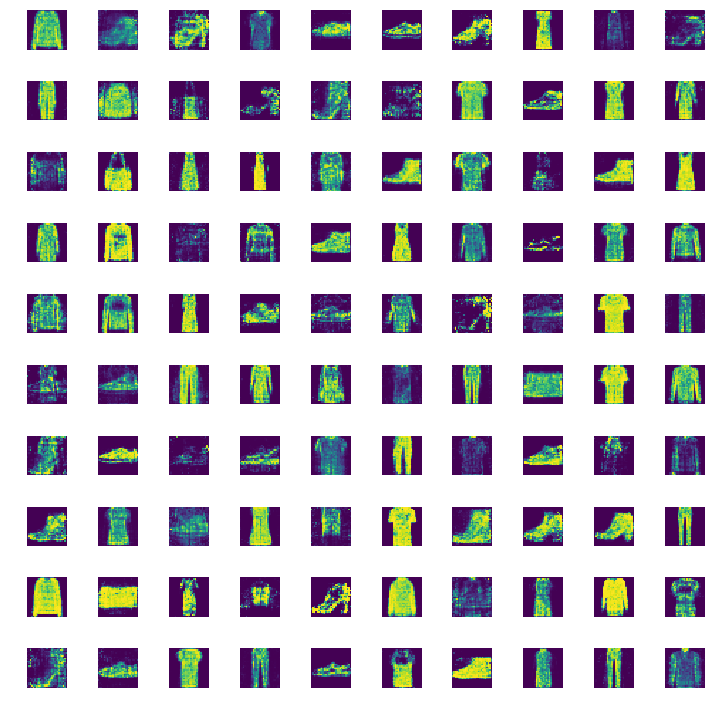

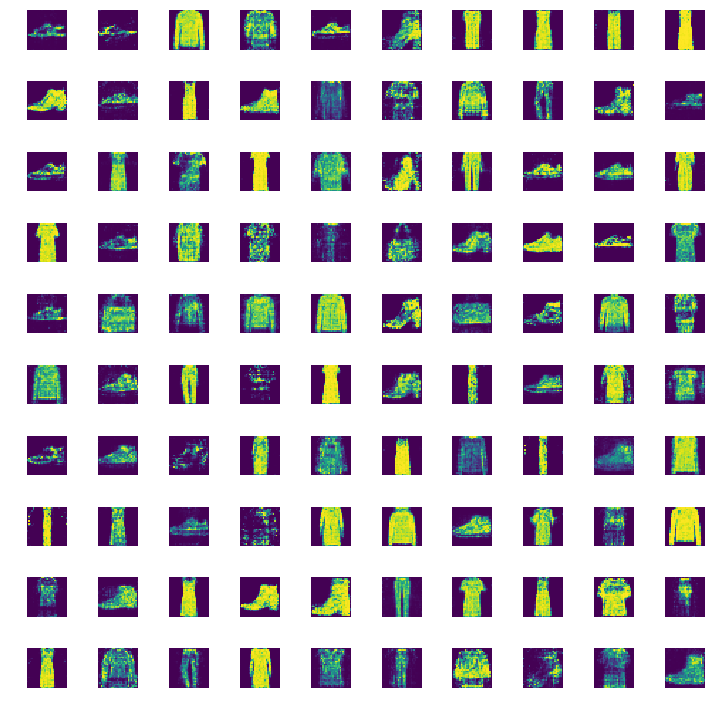

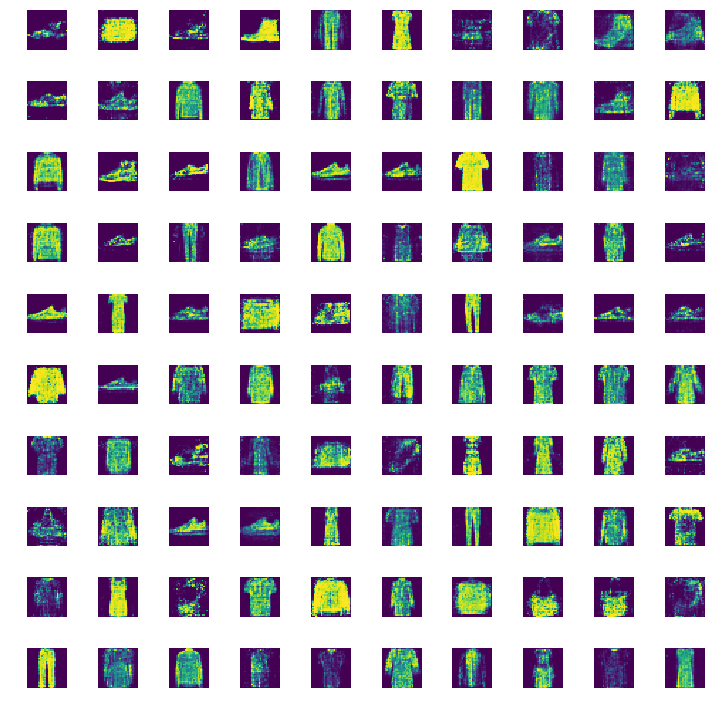

In [0]:
# training on fashion MNIST dataset

training(XFash_train, yFash_train,
         XFash_test, yFash_test,
         epochs=400,batch_size=128)